## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import heapq

## Heap

In [2]:
# Heap for NN
class KHeap():
  def __init__(self, capacity, invert=False):
    self.capacity = capacity
    self.data = []
    self.mult = -1 if invert else 1 

  def push(self, elem):
    elem[0] = self.mult * elem[0]
    if len(self.data) < self.capacity:
      heapq.heappush(self.data, elem)
    elif elem < self.data[0]:
      heapq.heappop(self.data)
      heapq.heappush(self.data, elem)

## BirdFlockSimulator

In [3]:
class NearestNeighbourCalculator:
  
  def __init__(self, neighBoursN):
    self.neighboursN = neighBoursN
  
  def getNNDf(self, df):
    res = []
    for i in range(len(df)):
      res.append(self.getNeighbours(i, df))
    nndf = pd.DataFrame(np.array(res))
    nndf = nndf.rename(mapper=self.mapColNames, axis='columns')
    return pd.concat([df, nndf], axis='columns')

  # Nearest Neighbours
  def getNeighbours(self, i, df):
    bird = df.iloc[i]
    maxHeap = KHeap(self.neighboursN, True)
    minHeap = KHeap(1)
    for index, row in df.iterrows():
      if i == index:
        continue
      dist = abs(row.x-bird.x) ** 2 + abs(row.y-bird.y) ** 2
      maxHeap.push([dist, row])
      minHeap.push([dist, row])
    maxHeap.data.sort()
    nn = np.array(
      [[math.sqrt(-x[0]), x[1][0], x[1][1]]
      for x in reversed(maxHeap.data)]).flatten()
    return nn

  def mapColNames(self, col):
    nnn = col//3
    label = ""
    if col % 3 == 0:
      label = "dist"
    elif col % 3 == 1:
      label = "x"
    else:
      label = "y"
    return f"nn_{nnn}_{label}"
  

In [4]:
class VectorCalculator:
  def __init__(self, neighBoursN):
    self.neighboursN = neighBoursN

  # Vector calculation
  def getVectors(self, df):
    # Calculate vector based on NN
    vectorData = []
    for index, row in df.iterrows():
      newXVector = 0.0
      newYVector = 0.0
      for i in range(self.neighboursN):
        xDiff, yDiff = self.calcVector(row, (row[f"nn_{i}_x"], row[f"nn_{i}_y"], row[f"nn_{i}_dist"]))
        newXVector += xDiff
        newYVector += yDiff
      xVector = newXVector + row.vx
      yVector = newYVector + row.vy
      # Take vectors and combine with current velocity
      vectorData.append(np.array([xVector, yVector]))
    ret = pd.DataFrame(np.array(vectorData))
    ret.columns = ["x", "y"]
    return ret
  
  # Alternative, use the vectors of the 5 closest neightbours instead?
  def calcVector(self, bird, neighbour):
    neighbourX, neighbourY, neighbourDist = neighbour
    vecX = neighbourX-bird.x
    vecY = neighbourY-bird.y
    # If neighbour is greater than 15, we want to be attracted to a point 10 away
    if neighbourDist >= 15:
      attraction = neighbourDist-10
      attractionFactor = 0.1
      return self.normalizeVector(vecX, vecY, attraction*attractionFactor)
    # If neighbour is less than 10, repulse them based on how close they are
    # Push away linearly
    elif neighbourDist <= 5:
      repulsion = 10-neighbourDist
      repulsionFactor = 0.1
      return self.normalizeVector(-vecX, -vecY, repulsion*repulsionFactor)
    # Else, maintain current vector
    else:
      return (0, 0)
  
  def normalizeVector(self, x, y, scale=1):
    hyp = math.sqrt(x**2 + y**2)
    return ((x/hyp)*scale, (y/hyp)*scale)

In [5]:
class BirdFlockSimulator:

  # Init
  def __init__(self, numBirds):
    self.numBirds = numBirds
    self.maxX = 100
    self.maxY = 100
    self.neighboursN = 5
    self.birds = self.createBirdsDataframe()

  def createBirdsDataframe(self):
    d = {
      'x': np.random.rand(self.numBirds) * self.maxX,
      'y': np.random.rand(self.numBirds) * self.maxY,
      'vx' : np.random.rand(self.numBirds) * 10,
      'vy' : np.random.rand(self.numBirds) * 10
    }
    return pd.DataFrame(data=d)

  def tick(self):
    # NN
    nnCalc = NearestNeighbourCalculator(self.neighboursN)
    self.nnDf = nnCalc.getNNDf(self.birds)
    # Vectors
    vCalc = VectorCalculator(self.neighboursN)
    vectors = vCalc.getVectors(self.nnDf)

    # Create new df
    newD = self.birds[['x', 'y']] + vectors
    vectors.columns = ['vx', 'vy']
    self.birds = pd.concat([newD, vectors], axis=1)

  

## Test

In [6]:
sim = BirdFlockSimulator(100)

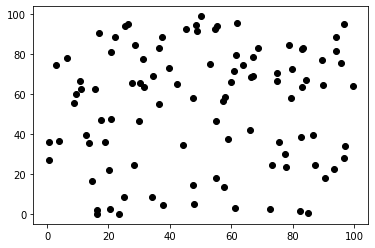

In [7]:
curr = sim.birds
plt.plot(curr.x, curr.y, 'o', color='black')

In [8]:
curr

,x,y,vx,vy
0,84.456291,67.059862,4.931517,9.739355
1,39.829285,73.171899,6.182743,7.145990
2,68.769201,82.982219,0.160641,9.524323
3,14.773893,16.483064,9.619418,0.446462
4,17.481418,46.850473,8.462355,7.998011
...,...,...,...,...
95,87.383640,24.524459,5.238585,1.169182
96,67.012469,68.894508,0.305936,2.157054
97,9.400690,60.217798,1.842499,7.855805
98,83.220729,82.502978,6.967021,7.777607


In [9]:
for i in range(10):
  sim.tick()

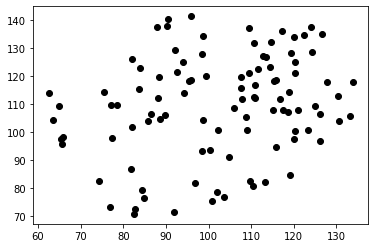

In [10]:
curr = sim.birds
plt.plot(curr.x, curr.y, 'o', color='black')

In [11]:
curr

,x,y,vx,vy
0,116.763230,111.662224,-16.035974,-4.058437
1,133.852277,117.819021,24.287640,-6.658211
2,98.374390,127.705389,-20.009235,-1.349859
3,115.882306,118.598745,44.403370,36.645267
4,110.808068,116.668960,29.815809,16.319353
...,...,...,...,...
95,123.267239,100.664186,-20.122938,23.200536
96,95.806325,118.590151,-21.228046,-12.466739
97,65.706045,95.582040,0.783019,-0.996728
98,112.698704,127.180644,-12.912292,-2.100902


In [12]:
for i in range(30):
  sim.tick()

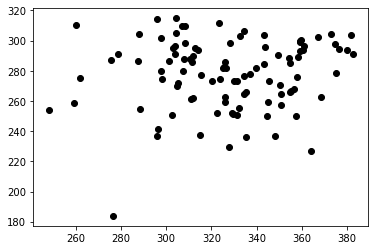

In [13]:
curr = sim.birds
plt.plot(curr.x, curr.y, 'o', color='black')